In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date, timedelta
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from datetime import datetime
from scipy.signal import find_peaks

In [ ]:
#Load Data
data = pd.read_csv("Data/Nat_Gas.csv")
#Convert to datetime object
data["Dates"] = pd.to_datetime(data["Dates"])
#Set index to dates and frequency to month end
data = data.set_index("Dates").asfreq('ME')

/var/folders/bg/5dmr_ymn0g7d0fqz7043vr8c0000gp/T/ipykernel_45771/3214635457.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Dates"] = pd.to_datetime(data["Dates"])


In [3]:
dp = DeterministicProcess(
    index=data.index,       # Must be a DatetimeIndex
    constant=True,
    order=1,
    seasonal=True,
    drop=True
)
X = dp.in_sample()
seasonality = LinearRegression()
seasonality.fit(X, data["Prices"])
X_future = dp.out_of_sample(60)  # Works now

In [4]:
train_res = pd.DataFrame({
    "Time": X.index.map(lambda x: x.timestamp()), 
    "Prediction": seasonality.predict(X)
})
test_res = pd.DataFrame({
    "Time": X_future.index.map(lambda x: x.timestamp()),
    "Prediction":seasonality.predict(X_future)
})

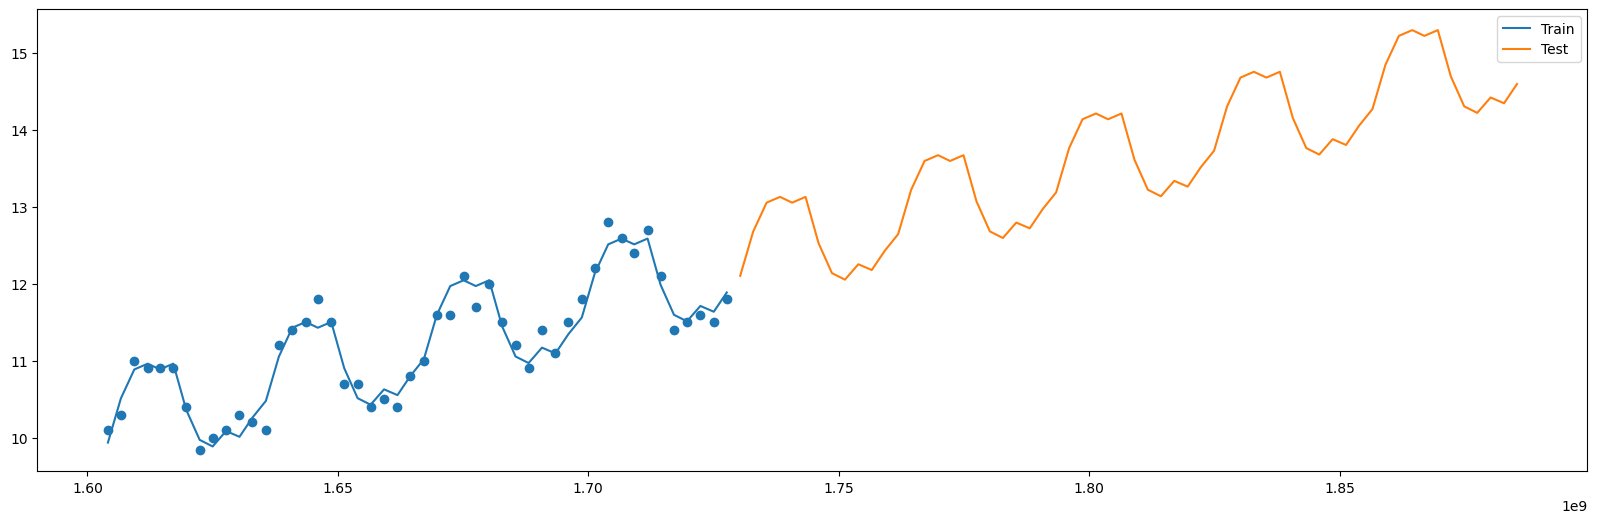

In [5]:
plt.figure(figsize=(20,6))
plt.plot(train_res["Time"], train_res["Prediction"], label = "Train")
plt.scatter(data.index.map(lambda x: x.timestamp()), data["Prices"])
plt.plot(test_res["Time"], test_res["Prediction"], label = "Test")
plt.legend()
plt.show()

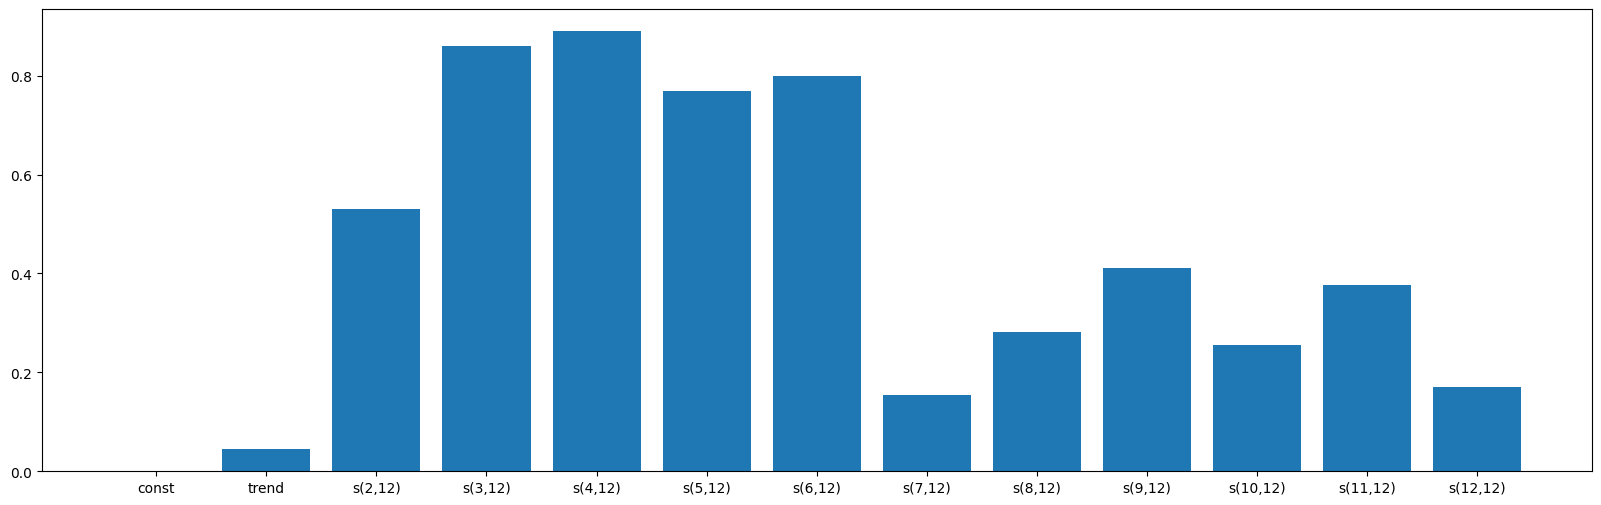

In [6]:
ranked_features = pd.DataFrame({
    "Feature":X.columns,
    "Importance":seasonality.coef_
})
plt.figure(figsize=(20,6))
plt.bar(x = ranked_features["Feature"], height = ranked_features["Importance"].map(lambda x: abs(x)))
plt.show()

In [7]:
model_data = pd.concat([train_res, test_res], axis = 0)
model_data = model_data.set_index(np.arange(0, model_data.shape[0]))

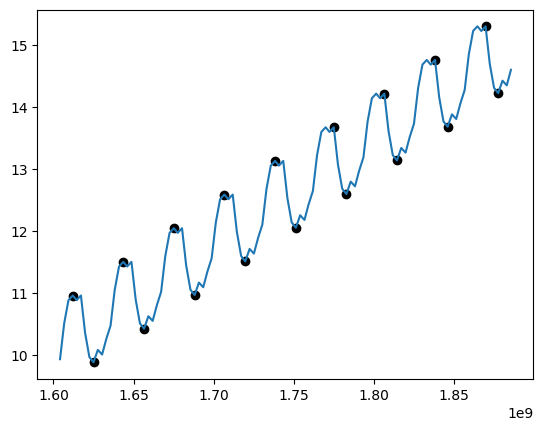

,Injection Times,Injection Prices,Withdrawing Times,Withdrawing Prices
0,1.625011e+09,9.88775,1.612051e+09,10.96275
1,1.656547e+09,10.42925,1.643587e+09,11.50425
2,1.688083e+09,10.97075,1.675123e+09,12.04575
3,1.719706e+09,11.51225,1.706659e+09,12.58725
4,1.751242e+09,12.05375,1.738282e+09,13.12875
5,1.782778e+09,12.59525,1.774915e+09,13.67025
6,1.814314e+09,13.13675,1.806451e+09,14.21175
7,1.845936e+09,13.67825,1.838074e+09,14.75325
8,1.877472e+09,14.21975,1.869610e+09,15.29475


In [8]:
model_data = model_data.set_index(np.arange(0, model_data.shape[0]))
max_peaks, _ = find_peaks(model_data["Prediction"], distance= 12) #yearly maxes
min_peaks, _ = find_peaks(-model_data["Prediction"], distance = 12) # yearly minimums
for index in max_peaks:
    plt.scatter(model_data["Time"][index], model_data["Prediction"][index], color = "black")
for index in min_peaks:
    plt.scatter(model_data["Time"][index], model_data["Prediction"][index], color = "black")
plt.plot(model_data["Time"], model_data["Prediction"])
plt.show()
times= pd.DataFrame({
    "Injection Times": [model_data["Time"][index] for index in min_peaks],
    "Injection Prices": [model_data["Prediction"][index] for index in min_peaks],
    "Withdrawing Times": [model_data["Time"][index] for index in max_peaks],
    "Withdrawing Prices": [model_data["Prediction"][index] for index in max_peaks]
    
})
times

In [20]:
pd.to_datetime(times["Injection Times"], unit='s', utc=True)

0   2021-06-30 00:00:00+00:00
1   2022-06-30 00:00:00+00:00
2   2023-06-30 00:00:00+00:00
3   2024-06-30 00:00:00+00:00
4   2025-06-30 00:00:00+00:00
5   2026-06-30 00:00:00+00:00
6   2027-06-30 00:00:00+00:00
7   2028-06-30 00:00:00+00:00
8   2029-06-30 00:00:00+00:00
Name: Injection Times, dtype: datetime64[ns, UTC]

In [ ]:
model_data.to_csv("Data/pricing_forecast_results.csv")
times.to_csv("Data/pricing_by_dates.csv")